In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import scipy as sp
import netCDF4 as nc
from netCDF4 import Dataset
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy
import matplotlib.path as mpath
import matplotlib.ticker as mticker
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
from eofs.standard import Eof
import cdo
from cartopy.util import add_cyclic_point
import xarray as xr
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from numpy import save
from numpy import asarray
from numpy import load

In [57]:
dataset = load('C:/Users/hoonc/AO/Data/data_set.npy')
print(dataset.shape)

(852, 72, 36, 4)


In [3]:
train_set = dataset[:600,:,:,:]
print(train_set.shape)
valid_set = dataset[600:720,:,:,:]
print(valid_set.shape)
test_set = dataset[720:,:,:,:]
print(test_set.shape)

(600, 72, 36, 4)
(120, 72, 36, 4)
(120, 72, 36, 4)


In [60]:
train_set_2 = []
train_set_3 = []
for k in range(8,11):
    train_set_1 = []
    for j in  range(60,70):
        train = dataset[k+12*j,:,:,:]
        train_set_1.append(train)
    train_set_2 = np.ma.stack(train_set_1)
    train_set_3.append(train_set_2)
    print(train_set_2.shape)
train_set_3 = np.concatenate(train_set_3, axis=-1)
print(train_set_3.shape)

(10, 72, 36, 4)
(10, 72, 36, 4)
(10, 72, 36, 4)
(10, 72, 36, 12)


In [62]:
train_set_2 = []
train_set_3 = []
for k in range(8,11):
    train_set_1 = []
    train = dataset[k+12*70,:,:,:]
    train_set_1.append(train)
    train_set_2 = np.ma.stack(train_set_1)
    train_set_3.append(train_set_2)
    print(train_set_2.shape)
train_set_3 = np.concatenate(train_set_3, axis=-1)
print(train_set_3.shape)

(1, 72, 36, 4)
(1, 72, 36, 4)
(1, 72, 36, 4)
(1, 72, 36, 12)


In [63]:
data = asarray(train_set_3)
save('C:/Users/hoonc/AO/Data/test_SON.npy', data)

In [48]:
# Load dataset
data_hgt = Dataset('C:/Users/hoonc/AO/Data/hgt.mon.mean.nc', 'r')

In [49]:
print(list(data_hgt.variables))

['level', 'lat', 'lon', 'time', 'hgt']


In [50]:
print(data_hgt.variables['level'][:])

[1000.  925.  850.  700.  600.  500.  400.  300.  250.  200.  150.  100.
   70.   50.   30.   20.   10.]


In [54]:
# calculate 1979-2000 mean
hgt1 = data_hgt.variables['hgt'][372:624,5,0:36,:] #1000lev -> 0, 500lev -> 5
#hgt2 = add_cyclic_point(hgt1)
lons1 = data_hgt.variables['lon'][:]
#lons2 = list(lons1[:])
#lons2.append(360)
lats1 = data_hgt.variables['lat'][0:36]
time1 = data_hgt.variables['time'][:]
i = 0
hgt_year_list = []
while i <= 251:
    hgt_year = hgt1[i,:,:]
    hgt_year_list.append(hgt_year)
    i +=1
hgt_year_nc = np.ma.stack(hgt_year_list)
hgt1_mean = hgt_year_nc.mean(axis=0)
std = np.std(hgt1_mean)

C:\Users\hoonc\Anaconda3\lib\site-packages\cartopy\mpl\geoaxes.py:385: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


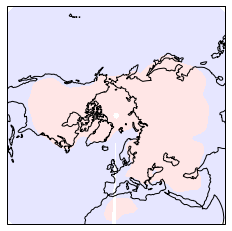

In [5]:
hgt1_final = hgt_year_nc - hgt1_mean
coslat = np.cos(np.deg2rad(lats1)).clip(0.,1.)
wgts = np.sqrt(coslat)[..., np.newaxis]
solver1 = Eof(hgt1_final, weights = wgts)
eof1 = solver1.eofsAsCovariance(neofs=1)
clevs = np.linspace(-75., 89., 11)
axx = plt.axes(projection = ccrs.NorthPolarStereo()) # Plotting
#axx.set_global()
axx.coastlines()
axx.set_extent([-180, 180, 20, 90], ccrs.PlateCarree()) # min lat: 25
axx.contourf(lons1, lats1, eof1.squeeze(), levels = clevs, cmap = 'bwr',
            transform = ccrs.PlateCarree(), extend = 'both')
plt.show()

In [55]:
def plott(startyear, endyear, plevel):
    # make training dataset
    sy = startyear-1948
    sm = sy*12          # start month
    ey = endyear-1948
    em = ey*12          # end month
    
    # Define variables
    level = np.squeeze(data_hgt.variables['level'][:])
    plev = np.where(level == plevel)[0] # input pressure level
    lon = np.squeeze(data_hgt.variables['lon'][:])
    lat = np.squeeze(data_hgt.variables['lat'][0:36]) # Northen Hemisphere (0N ~ 90N)
    time = np.squeeze(data_hgt.variables['time'][:])
    a = list(lon[:]) 
    a.append(360) # adding longitude 360 for removing a white line
    
    # colour scheme
    hgt_list = []
    # Loop for each month
    # imaging -> making an array -> combining the array
    for t in range(sm, em):
        hgt = np.squeeze(data_hgt.variables['hgt'][t,plev,0:36,:]) #retrieve hgt for t
        var = np.squeeze(np.mean(data_hgt.variables['hgt'][t,plev,0:36,:])) # Calculate mean
        var_anom = var - hgt # Calculate anomaly
        hgt_ano = (var_anom - hgt1_mean)/std # anomaly based on 1979-2000
        array =[]
        array1 = hgt_ano[:,0::2]; array1.filled(fill_value = 0)
        array2 = hgt_ano[:,1::2]; array2.filled(fill_value = 0)
        array.append(array1); array.append(array2)
        array_syn = np.ma.stack(array)
        array_mean = array_syn.mean(axis=0)
        '''
        array1.append(array2)
        array_syn = np.ma.stack(array1)
        array_mean = array_syn.mean(axis=0)
        '''
        hgt_list.append(array_mean)
        
    hgt_year_nc = np.ma.stack(hgt_list)
    #print(hgt_year_nc[0,:,:].shape)
    #print(hgt_year_nc.shape)
    '''
    ncf = Dataset('C:/Users/hoonc/AO/Data/hgt_ddyear.nc', 'w', 'netCDF4')
    ncf.createDimension('lon', 72)
    ncf.createDimension('lat', 36)
    ncf.createDimension('time,', None)
    lons = ncf.createVariable('lon','float32',('lon'))
    lons[:] = np.arange(0., 72., 1.)
    lats = ncf.createVariable('lat','float32',('lat'))
    lats[:] = np.arange(0., 72., 1.)
    times = ncf.createVariable('time','float64',('time'))
    hgt = ncout.createVariable('hgt','float32',('time','lat','lon'));
    for i in range(0,852):
        hgt[i,:,:] = hgt_year_nc[i,:,:]    
    ncf.close()
    '''
    data = asarray(hgt_year_nc)
    save('C:/Users/hoonc/AO/Data/hgt_500.npy', data)
    return(print("job done"))

In [56]:
plott(1950, 2021, 500)

job done
